In [51]:
import diffraction_code 
from diffraction_code import Diffraction
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d

In [52]:
##Gaussian with analytic solution 
def gaussian_analytic(L,N,lam,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    X, Y = np.meshgrid(x, y)
    
    w = 1e-2

    k = np.pi*2/lam
    
    fd = (1/np.sqrt(1+(2*z/(k*w**2))**2))*np.e**((-1/(w**2))*(X**2+Y**2)/(1+(2*z/(k*w**2))**2)+ 1j*k*z-1j*np.arctan(2*z/(k*w**2)) + (1j*k/(2*z))*((X**2+Y**2)/(1+(k*w**2/(2*z))**2)))
    
    return fd

##Gaussian Initial Condition
def gaussian(L,N,lam,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    X, Y = np.meshgrid(x, y)
    w = 1e-2
    f = np.e**(-(X**2 + Y**2)/(w**2))
    return f

##Circular aperature initial condition
def circular_aperature(L,N,lam,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    X, Y = np.meshgrid(x, y)
    r_0 = 1e-3
    x_0 = 0
    y_0 = 0
    z_0 = -3e-2
    A = 3e-2

    k = np.pi*2/lam
    z1 = 0

    circ = np.sqrt(X**2 + Y**2)/r_0

    for i in range(len(x)):
        for j in range(len(y)): 
            if circ[i,j] > 1:
                circ[i,j] = 0
            else: 
                circ[i,j] = 1
            
    f = A*circ*(np.e**(1j*k*np.sqrt((X-x_0)**2 + (Y-y_0)**2 + (z1-z_0)**2)))/np.sqrt((X-x_0)**2 + (Y-y_0)**2 + (z1-z_0)**2)  
    return f

Error with fixed dx

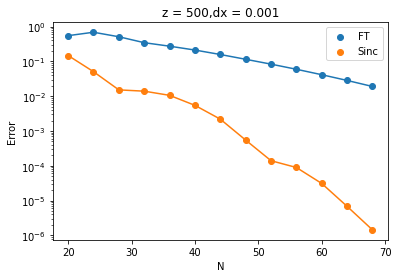

In [53]:
error_sinc = []
grid_sinc = []
error_four = []
grid_four = []
for N in range(20,70,4):
    dx = 1e-3
    L = N*dx
    z = 500
    lam = 1e-6
    initial = gaussian(L,N,lam,z)

    solutions = Diffraction(initial,L,N,lam,z)

    fd = gaussian_analytic(L,N,lam,z)
    U = solutions.sinc_solution()
    
    error_sinc.append(np.linalg.norm(abs(fd) - abs(U))/np.linalg.norm(abs(fd)))
    grid_sinc.append(N)

    FT = solutions.fft_solution()
                      
    error_four.append(np.linalg.norm(abs(fd) - abs(FT))/np.linalg.norm(abs(fd)))
    grid_four.append(N)
    
plt.plot(grid_four,error_four)
plt.scatter(grid_four,error_four,label = 'FT')
plt.plot(grid_sinc,error_sinc)
plt.scatter(grid_sinc,error_sinc,label = 'Sinc')
plt.title('z = ' + str(z) + ',dx = ' + str(dx))
plt.ylabel('Error')
plt.xlabel('N')
plt.yscale('log')
plt.legend()
plt.show()

Error with fixed L

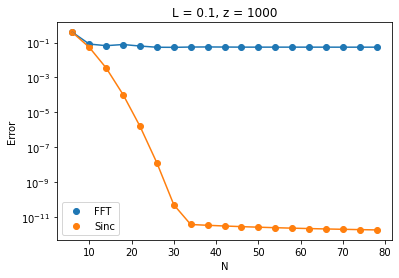

In [55]:
error_sinc = []
error_fft = []
grid_N = []

for N in range(6,80,4):
    L = 1e-1
    dx = L/N
    z = 1000
    lam = 1e-6
    
    initial = gaussian(L,N,lam,z)

    solutions = Diffraction(initial,L,N,lam,z)
    
    sinc_sol = solutions.sinc_solution()
    
    analytic_sol = gaussian_analytic(L,N,lam,z)
    
    error_sinc.append(np.linalg.norm(abs(sinc_sol) - abs(analytic_sol))/np.linalg.norm(abs(analytic_sol)))
    
    fft_sol = solutions.fft_solution()

    error_fft.append(np.linalg.norm(abs(fft_sol) - abs(analytic_sol))/np.linalg.norm(abs(analytic_sol)))
    
    grid_N.append(N)
    
plt.plot(grid_N,error_fft)
plt.scatter(grid_N,error_fft,label = 'FFT')
plt.plot(grid_N,error_sinc)
plt.scatter(grid_N,error_sinc,label = 'Sinc')
plt.title('L = ' + str(L) + ', z = ' + str(z))
plt.ylabel('Error')
plt.xlabel('N')
plt.yscale('log')
plt.legend()
plt.show()

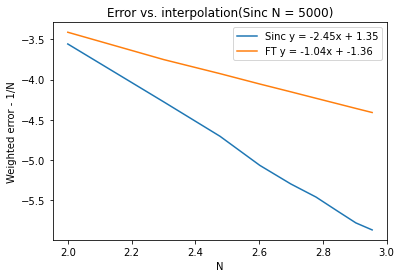

In [56]:
master_sinc = np.load('Master_sinc.npy')
N= 5000
L = 4e-3
dx = L/N
x = np.linspace(-L/2,L/2-dx,N)
y = np.linspace(-L/2,L/2-dx,N)

interp_sol = interp2d(x, y, abs(master_sinc),kind = 'quintic')

sinc_error_weight = []
sinc_error_rel = []
ft_error_weight = []
ft_error_rel = []


N_steps = np.arange(100,1000,100)

for i in range(len(N_steps)):
    N = N_steps[i]
    dx = L/N
    z = .015
    lam = 1e-5
    xnew = np.linspace(-L/2,L/2-dx,N)
    ynew = np.linspace(-L/2,L/2-dx,N)
    interp = interp_sol(xnew,ynew)
    initial = circular_aperature(L,N,lam,z)
    solutions = Diffraction(initial,L,N,lam,z)
    sinc = solutions.sinc_solution()
    ft = solutions.fft_solution()
    sinc_error_weight.append(np.linalg.norm(abs(interp) - abs(sinc))/N**2)
    ft_error_weight.append(np.linalg.norm(abs(interp) - abs(ft))/N**2)
    
A1 = np.vstack([np.log10(N_steps), np.ones(len(np.log10(N_steps)))]).T
a_sinc,b_sinc = np.linalg.lstsq(A1,np.log10(sinc_error_weight),rcond = -1)[0]
a_fft,b_fft = np.linalg.lstsq(A1,np.log10(ft_error_weight),rcond = -1)[0]
    
plt.plot(np.log10(N_steps),np.log10(sinc_error_weight),label = 'Sinc y = ' + str(np.round(a_sinc,decimals = 2))+'x + ' + str(np.round(b_sinc,decimals = 2)))
plt.plot(np.log10(N_steps),np.log10(ft_error_weight),label = 'FT y = ' + str(np.round(a_fft,decimals = 2))+'x + ' + str(np.round(b_fft,decimals = 2)))
plt.xlabel('N')
plt.ylabel('Weighted error - 1/N')
plt.title('Error vs. interpolation(Sinc N = 5000)')
plt.legend()
plt.show()

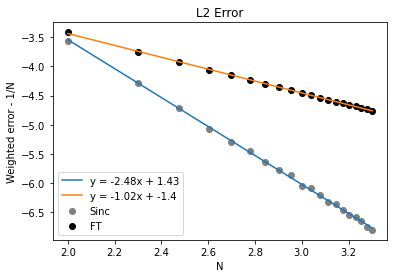

In [57]:
sinc_error_weight = np.load('sinc_error_weight.npy')
ft_error_weight = np.load('ft_error_weight.npy')
# np.save('sinc_error_weight',sinc_error_weight)
# np.save('ft_error_weight',ft_error_weight)
N_steps = np.arange(100,2100,100)
A1 = np.vstack([np.log10(N_steps), np.ones(len(np.log10(N_steps)))]).T
a_sinc,b_sinc = np.linalg.lstsq(A1,np.log10(sinc_error_weight),rcond = -1)[0]
a_fft,b_fft = np.linalg.lstsq(A1,np.log10(ft_error_weight),rcond = -1)[0]
# np.round(a2,decimals = 2)
    
plt.plot(np.log10(N_steps),a_sinc*np.log10(N_steps)+b_sinc,label = 'y = ' + str(np.round(a_sinc,decimals = 2))+'x + ' + str(np.round(b_sinc,decimals = 2)))
plt.plot(np.log10(N_steps),a_fft*np.log10(N_steps)+b_fft,label = 'y = ' + str(np.round(a_fft,decimals = 2))+'x + ' + str(np.round(b_fft,decimals = 2)))
plt.scatter(np.log10(N_steps),np.log10(sinc_error_weight),label = 'Sinc',c = 'gray')
plt.scatter(np.log10(N_steps),np.log10(ft_error_weight),label = 'FT',c = 'black')
plt.xlabel('N')
plt.ylabel('Weighted error - 1/N')
plt.title('L2 Error')
plt.legend()
plt.show()

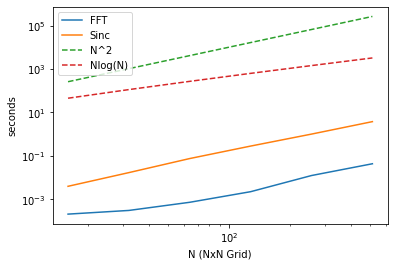

In [58]:
import time 

N_grid = np.array([2**4,2**5,2**6,2**7,2**8,2**9])
L = 2
lam = 1e-6
z=100

fft_times,sinc_times = [],[]

for N in N_grid:
    initial = gaussian(L,N,lam,z)
    solutions = Diffraction(initial,L,N,lam,z)
    add = 0
    iterations = 10
    for i in range(iterations):
        tic = time.time()
        solutions.fft_solution()
        toc = time.time()
        add += toc - tic
    fft_times.append(add/iterations)

    add = 0
    for i in range(iterations):
        tic = time.time()
        solutions.sinc_solution()
        toc = time.time()
        add += toc - tic
    sinc_times.append(add/iterations)

plt.loglog(N_grid,np.array(fft_times),label = 'FFT')
plt.loglog(N_grid,np.array(sinc_times),label = 'Sinc')
plt.loglog(N_grid,N_grid*N_grid,linestyle = 'dashed',label = 'N^2')
plt.loglog(N_grid,N_grid*np.log(N_grid),linestyle = 'dashed',label = 'Nlog(N)')
plt.xlabel("N (NxN Grid)")
plt.ylabel("seconds")
plt.legend()
plt.show()